In [48]:
from dataset import load_dataset
# from models.model_2_dropout_imp import ClimatePINN
from train import plot_comparison
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import xarray as xr
from visualisation import visualize_predictions
import json
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
from tqdm import tqdm
%matplotlib inline

In [57]:
dataset = load_dataset(
    1, 
    train_val_split = None, 
    year0=2000, 
    root_dir="./data/era_5_data",
    normalize=True)

In [58]:
idx = [0,1,2]
inputs, targets = dataset['train'][:]['input'], dataset['train'][:]['target']
geo500 , t850 = inputs[:,0,...], inputs[:,1,...]
t2m, u, v = targets[:,0,...], targets[:,1,...], targets[:,2,...]
inputs = (geo500 , t850)
targets = (t2m, u, v)

In [51]:
vars = (geo500 , t850, t2m, u, v)

corr_matrix = np.zeros((5,5))
vars_name = ['input:geo500', 'input:t850', 'target:t2m', 'target:u', 'target:v']
corr_matrix = np.zeros((5, 5, 32, 64))
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=-1, vmax=1)
for x, var_x in tqdm(enumerate(vars)):
    for y, var_y in enumerate(vars):
        corr = pearsonr(var_x, var_y)[0]
        corr_matrix[x,y] = corr

0it [00:00, ?it/s]

5it [00:06,  1.28s/it]


In [52]:
lon, lat= dataset['train'][0]['coords'][0], dataset['train'][0]['coords'][1]

In [53]:
len(lat.unique())

32

In [59]:
def transform_longitude(arr):
    # For longitude 64 points, split at index 32
    second_half = arr[:, :, :32]    # 0° to 180° (will stay 0° to 180°)
    first_half = arr[:, :, 32:]     # 180° to 360° (will become -180° to 0°)
    
    # Now we need to concatenate in the OPPOSITE order:
    # first the 180°-360° section (which becomes -180° to 0°)
    # then the 0°-180° section
    return torch.cat([first_half, second_half], axis=2)
t2m_2 = transform_longitude(t2m)

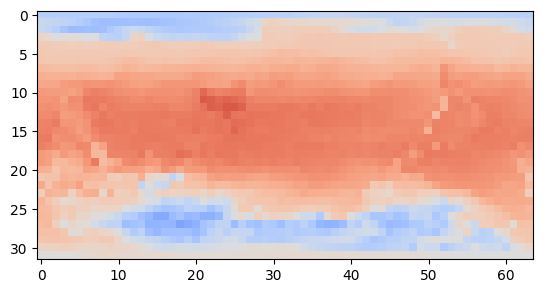

In [60]:

plt.imshow(t2m[4], cmap='coolwarm', vmin=t2m.min(), vmax=t2m.max())

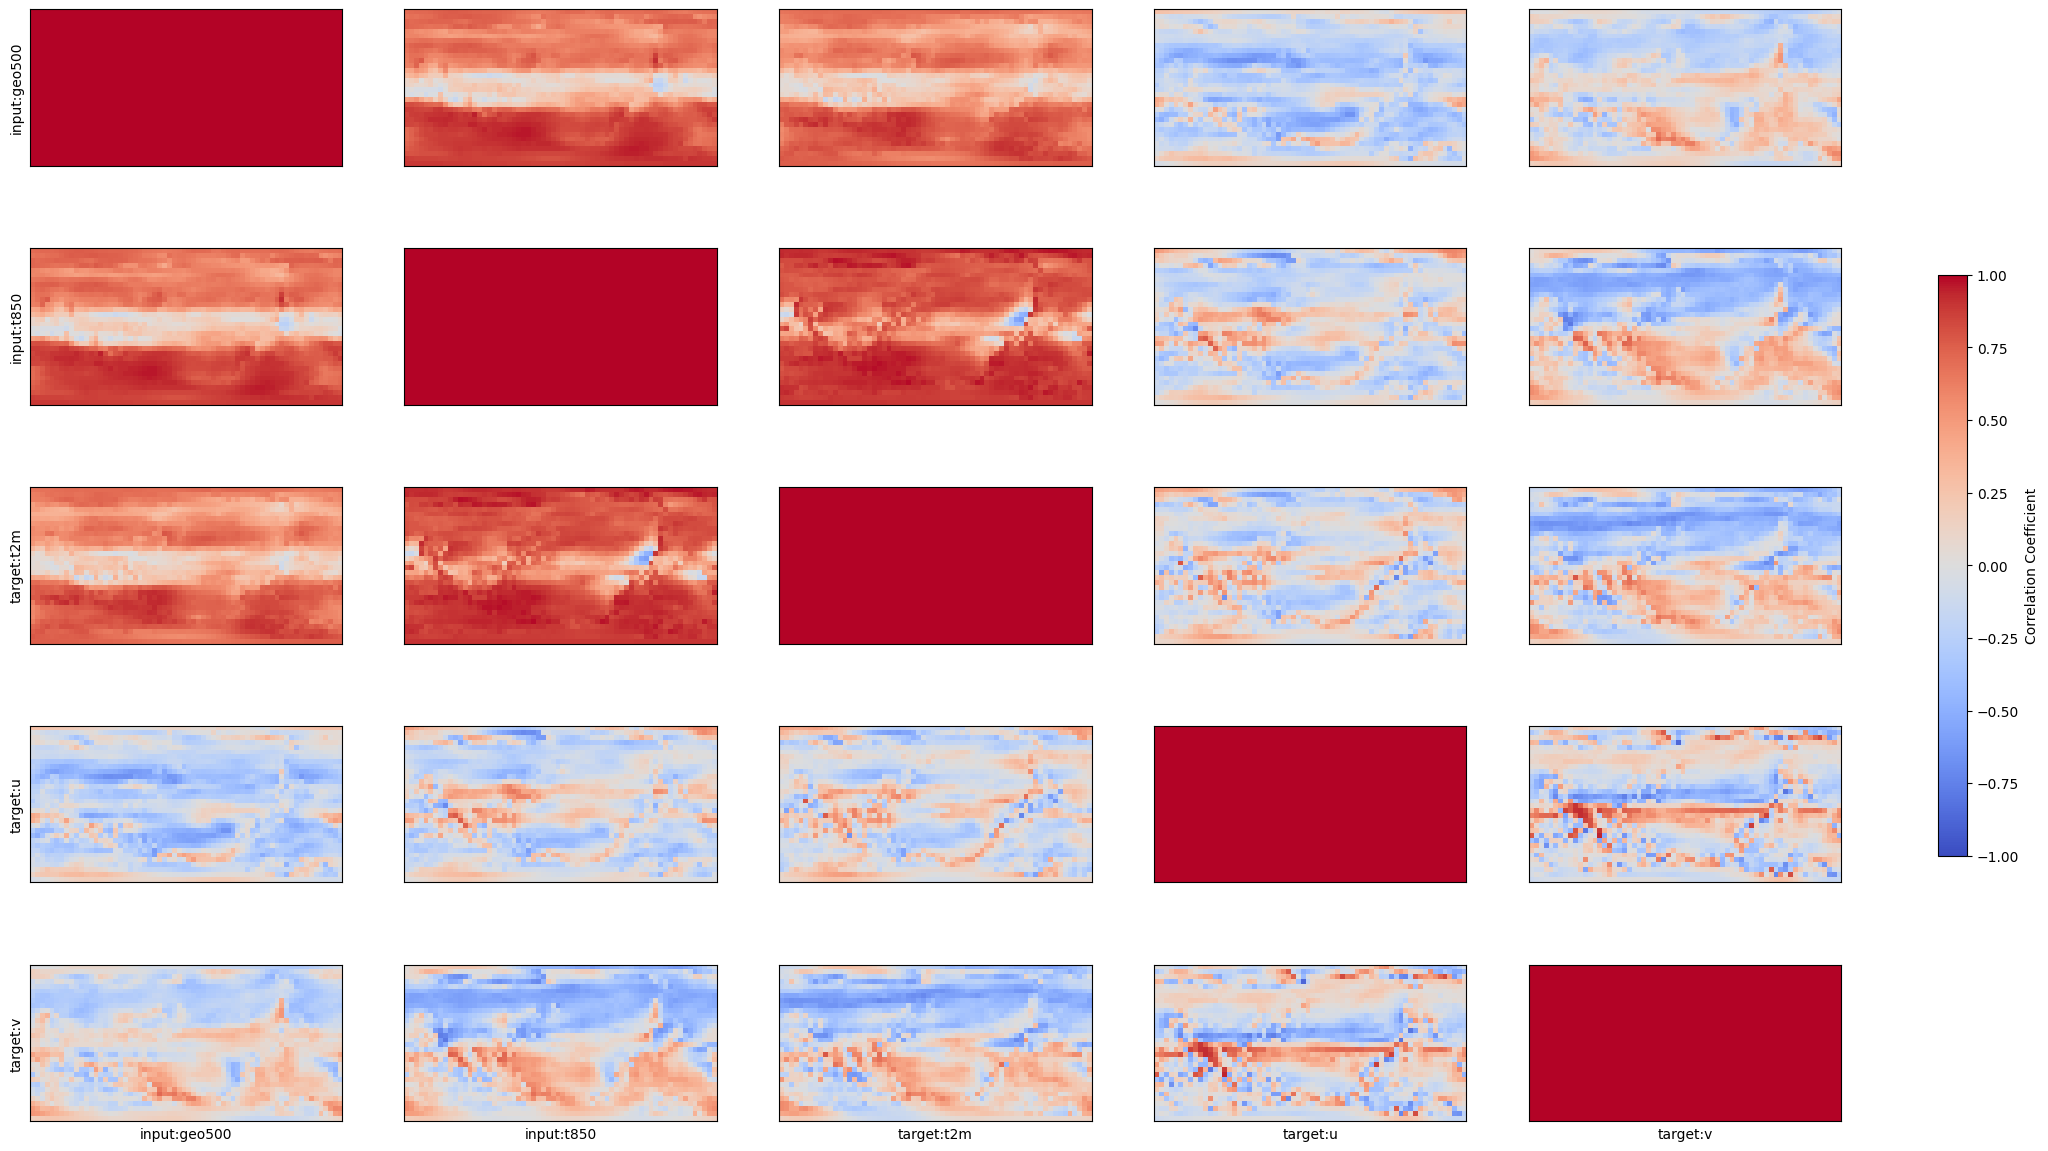

In [131]:
fig, axes = plt.subplots(5,5, figsize=(25,15))

for x, var_x in enumerate(vars):
    for y, var_y in enumerate(vars):
        ax = axes[x, y]
        im = ax.imshow(corr_matrix[x,y], vmin=-1, vmax=1, cmap='coolwarm',)
        ax.set_xticks([])
        ax.set_yticks([])

        if x==4:
            ax.set_xlabel(vars_name[y])
        if y==0:
            ax.set_ylabel(vars_name[x])

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.015, pad=0.05)
cbar.set_label('Correlation Coefficient')

5it [00:05,  1.14s/it]


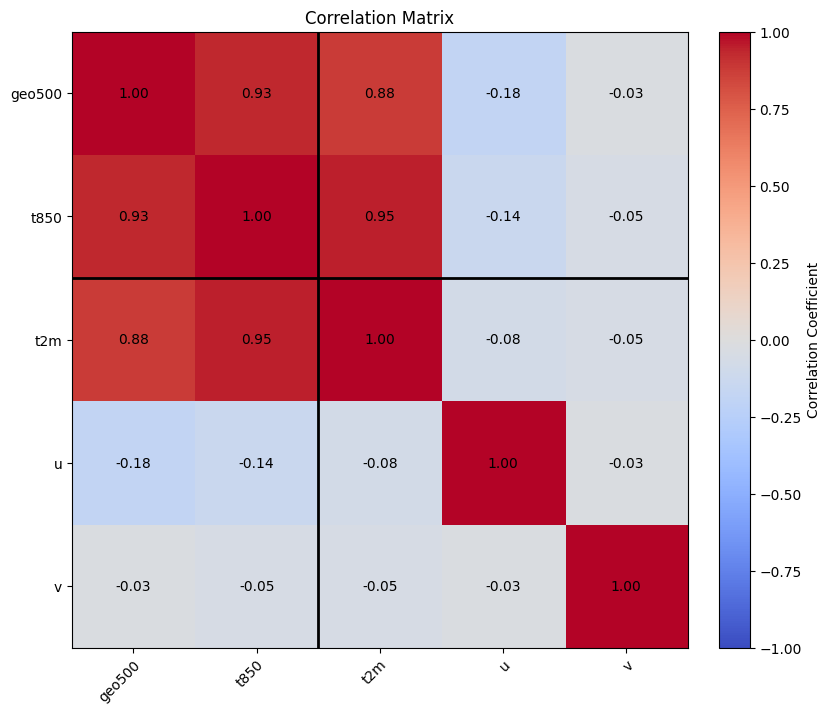

In [133]:
# Flatten the arrays
vars = (geo500.flatten(), t850.flatten(), t2m.flatten(), u.flatten(), v.flatten())
vars_name = ['geo500', 't850', 't2m', 'u', 'v']

# Compute the correlation matrix
corr_matrix = np.zeros((5, 5))
for x, var_x in tqdm(enumerate(vars)):
    for y, var_y in enumerate(vars):
        corr = pearsonr(var_x, var_y)[0]
        corr_matrix[x, y] = corr

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the correlation matrix
im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Add color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient')

# Add labels to the matrix
ax.set_xticks(np.arange(len(vars_name)))
ax.set_yticks(np.arange(len(vars_name)))
ax.set_xticklabels(vars_name)
ax.set_yticklabels(vars_name)

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add separators
ax.axvline(x=1.5, color='black', linewidth=2)
ax.axhline(y=1.5, color='black', linewidth=2)

# Annotate the cells with the correlation coefficients
for i in range(len(vars_name)):
    for j in range(len(vars_name)):
        text = ax.text(j, i, f"{corr_matrix[i, j]:.2f}",
                       ha="center", va="center", color="black")

# Add title
plt.title('Correlation Matrix')

# Show plot
plt.show()